# Image Clustering Using Sentence Transformer Library

### Clustering

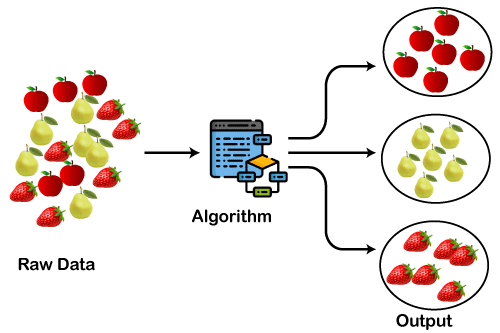

In [2]:
%pip install -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 667.1 kB/s eta 0:00:00 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 3.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 3.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 2.5 MB/s eta 0:00:00a 0:00:01m
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125940 sha256=bbc58bfd865d862f4ca6059edf3def6d85d42a4dd6e45bd77f037352f4417ef3
  Stored in directory: /Users/stanleysalvatierra/Library/Caches/pip/wheels/71/67/06/162a3760c40d74dd40bc855d527008d26341c2b0ecf3e8e11f
Successfully built sentence-transformers

[notice] A new release of pip available: 22.2.2 -> 23.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated pack

In [1]:
from sentence_transformers import SentenceTransformer, util
from PIL import Image
import glob
import torch
import pickle
import zipfile
from IPython.display import display
from IPython.display import Image as IPImage
import os
from tqdm.autonotebook import tqdm

#First, we load the respective CLIP model
model = SentenceTransformer('clip-ViT-B-32')


In [2]:
# import os
# import shutil
# from pathlib import Path

# def move_images_to_root(source_folder, destination_folder):
#     # Create the destination folder if it doesn't exist
#     if not os.path.exists(destination_folder):
#         os.makedirs(destination_folder)

#     # Iterate through the source folder and its subfolders
#     for folder, _, files in os.walk(source_folder):
#         for file in files:
#             # Check if the file has a valid image extension
#             if file.lower().endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff', '.webp')):
#                 # Construct the source and destination file paths
#                 src_path = os.path.join(folder, file)
#                 dst_path = os.path.join(destination_folder, file)

#                 # Handle potential naming conflicts
#                 counter = 1
#                 while os.path.exists(dst_path):
#                     file_name, file_extension = os.path.splitext(file)
#                     dst_path = os.path.join(destination_folder, f"{file_name}_{counter}{file_extension}")
#                     counter += 1

#                 # Move the file to the destination folder
#                 shutil.move(src_path, dst_path)

# if __name__ == "__main__":
#     source_folder = "./OTF Image Bank"
#     destination_folder = "myImages"
    
#     # If destination_folder does not exists it will be created
#     if os.path.exists(destination_folder):
#         os.rmdir(destination_folder)
        
#     move_images_to_root(source_folder, destination_folder)

In [3]:
import os
import shutil
from pathlib import Path

def get_images_paths(source_folder):
    # Create the destination folder if it doesn't exist

    images = []
    # Iterate through the source folder and its subfolders
    for folder, _, files in os.walk(source_folder):
        for file in files:
            # Check if the file has a valid image extension
            if file.lower().endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff', '.webp')):
                # Construct the source and destination file paths
                src_path = os.path.join(folder, file)

                images.append(src_path)
                # Handle potential naming conflicts
    return images
    
if __name__ == "__main__":
    source_folder = "./notebooks/OTF Image Bank"
    
    image_paths = get_images_paths(source_folder)

In [4]:
len(image_paths)

488

In [5]:
image_paths[0]

'./notebooks/OTF Image Bank/Drinks/cannedsoda.jpg'

In [8]:
# Next, we get about 25k images from Unsplash 
img_folder = './myImages/'
if not os.path.exists(img_folder) or len(os.listdir(img_folder)) == 0:
    os.makedirs(img_folder, exist_ok=True)
    
    photo_filename = 'unsplash-25k-photos.zip'
    if not os.path.exists(photo_filename):   #Download dataset if does not exist
        util.http_get('http://sbert.net/datasets/'+photo_filename, photo_filename)
        
    #Extract all images
    with zipfile.ZipFile(photo_filename, 'r') as zf:
        for member in tqdm(zf.infolist(), desc='Extracting'):
            zf.extract(member, img_folder)
        

  0%|          | 0.00/1.92G [00:00<?, ?B/s]

Extracting:   0%|          | 0/24996 [00:00<?, ?it/s]

In [6]:
# Now, we need to compute the embeddings
# To speed things up, we destribute pre-computed embeddings
# Otherwise you can also encode the images yourself.
# To encode an image, you can use the following code:
# from PIL import Image
# img_emb = model.encode(Image.open(filepath))
# img_folder = './myImages/'
# img_folder = image_paths
use_precomputed_embeddings = False

if use_precomputed_embeddings: 
    emb_filename = 'unsplash-25k-photos-embeddings.pkl'
    if not os.path.exists(emb_filename):   #Download dataset if does not exist
        util.http_get('http://sbert.net/datasets/'+emb_filename, emb_filename)
        
    with open(emb_filename, 'rb') as fIn:
        img_names, img_emb = pickle.load(fIn)  
    print("Images:", len(img_names))
else:
    # img_names = list(glob.glob('unsplash/photos/*.jpg'))
    # img_names = list(glob.glob(f'{img_folder}/*.jpg'))
    img_names = image_paths
    print("Images:", len(img_names))
    img_emb = model.encode([Image.open(filepath) for filepath in img_names], batch_size=128, convert_to_tensor=True, show_progress_bar=True)


Images: 488


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

In [7]:
img_emb.shape

torch.Size([488, 512])

In [8]:
# We have implemented our own, efficient method
# to find high density regions in vector space
def community_detection(embeddings, threshold, min_community_size=10, init_max_size=100):
    """
    Function for Fast Community Detection

    Finds in the embeddings all communities, i.e. embeddings that are close (closer than threshold).

    Returns only communities that are larger than min_community_size. The communities are returned
    in decreasing order. The first element in each list is the central point in the community.
    """

    # Compute cosine similarity scores
    cos_scores = util.cos_sim(embeddings, embeddings)

    # Minimum size for a community
    top_k_values, _ = cos_scores.topk(k=min_community_size, largest=True)

    # Filter for rows >= min_threshold
    extracted_communities = []
    for i in range(len(top_k_values)):
        if top_k_values[i][-1] >= threshold:
            new_cluster = []

            # Only check top k most similar entries
            top_val_large, top_idx_large = cos_scores[i].topk(k=init_max_size, largest=True)
            top_idx_large = top_idx_large.tolist()
            top_val_large = top_val_large.tolist()

            if top_val_large[-1] < threshold:
                for idx, val in zip(top_idx_large, top_val_large):
                    if val < threshold:
                        break

                    new_cluster.append(idx)
            else:
                # Iterate over all entries (slow)
                for idx, val in enumerate(cos_scores[i].tolist()):
                    if val >= threshold:
                        new_cluster.append(idx)

            extracted_communities.append(new_cluster)

    # Largest cluster first
    extracted_communities = sorted(extracted_communities, key=lambda x: len(x), reverse=True)

    # Step 2) Remove overlapping communities
    unique_communities = []
    extracted_ids = set()

    for community in extracted_communities:
        add_cluster = True
        for idx in community:
            if idx in extracted_ids:
                add_cluster = False
                break

        if add_cluster:
            unique_communities.append(community)
            for idx in community:
                extracted_ids.add(idx)

    return unique_communities

In [9]:
# Now we run the clustering algorithm
# With the threshold parameter, we define at which threshold we identify
# two images as similar. Set the threshold lower, and you will get larger clusters which have 
# less similar images in it (e.g. black cat images vs. cat images vs. animal images).
# With min_community_size, we define that we only want to have clusters of a certain minimal size
clusters = community_detection(img_emb, threshold=0.99, min_community_size=2)
print("Total number of clusters:", len(clusters))

Total number of clusters: 9


In [10]:
len(clusters)

9



Cluster size: 3
image_path:  ././notebooks/OTF Image Bank/Alcoholic/Martini/Cosmo.jpg


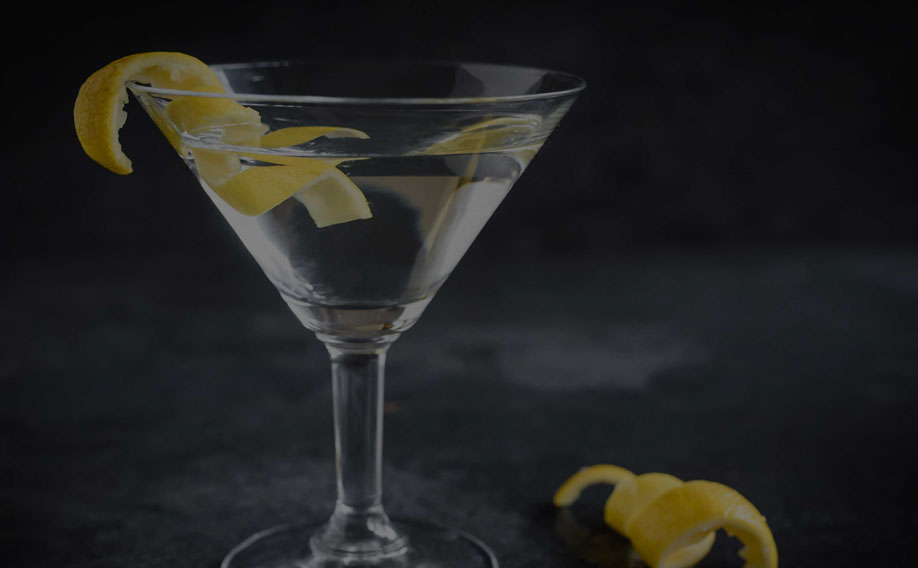

image_path:  ././notebooks/OTF Image Bank/Alcoholic/Martini/well.jpg


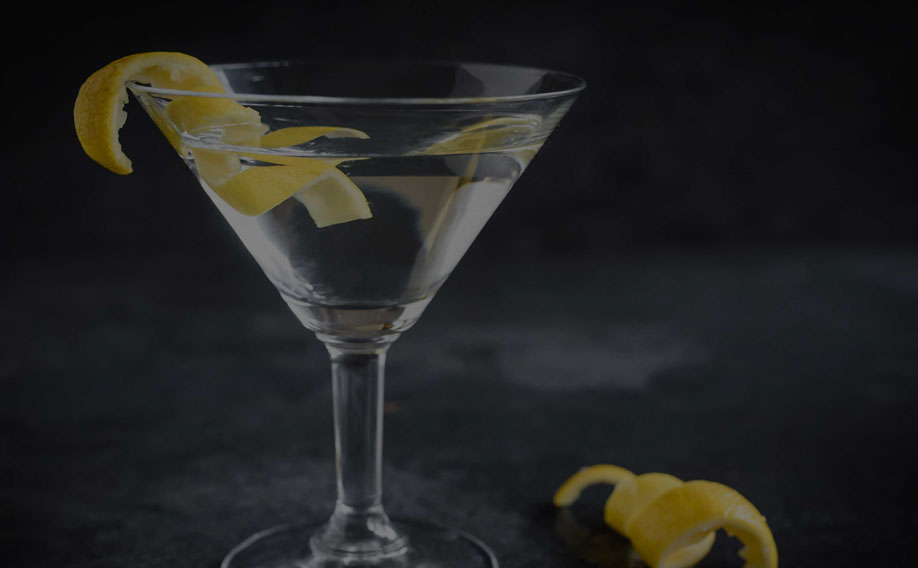

image_path:  ././notebooks/OTF Image Bank/Alcoholic/Martini/stoli.jpg


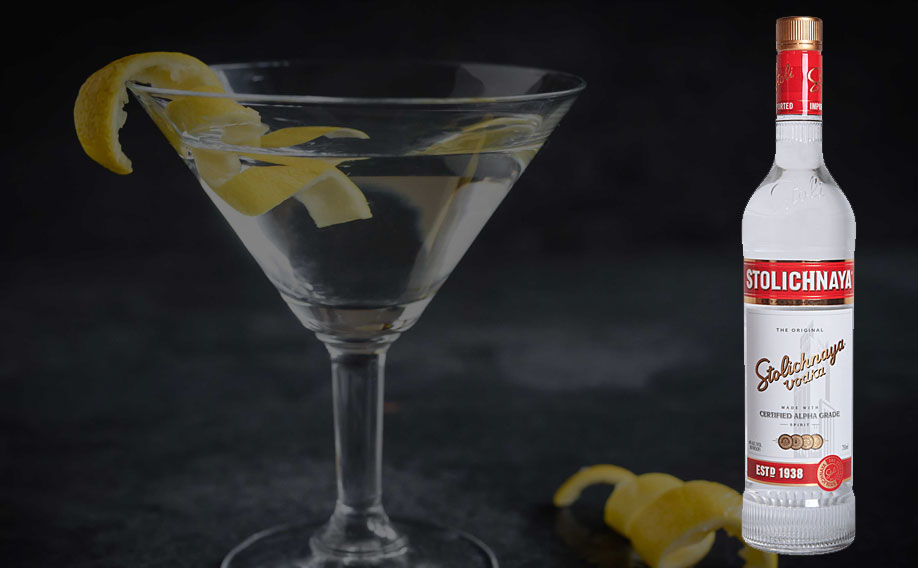



Cluster size: 2
image_path:  ././notebooks/OTF Image Bank/Drinks/dietcoke.jpg


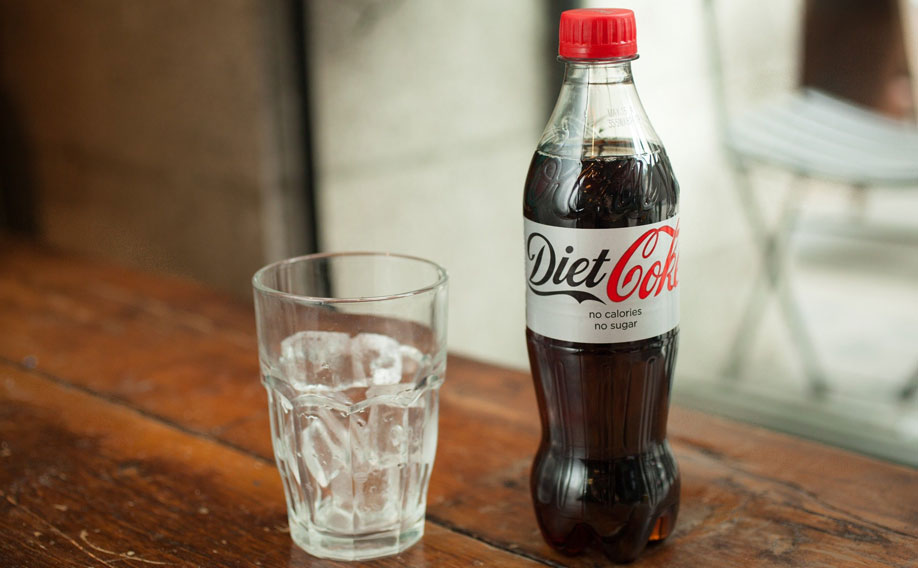

image_path:  ././notebooks/OTF Image Bank/Drinks/diet_coke.jpg


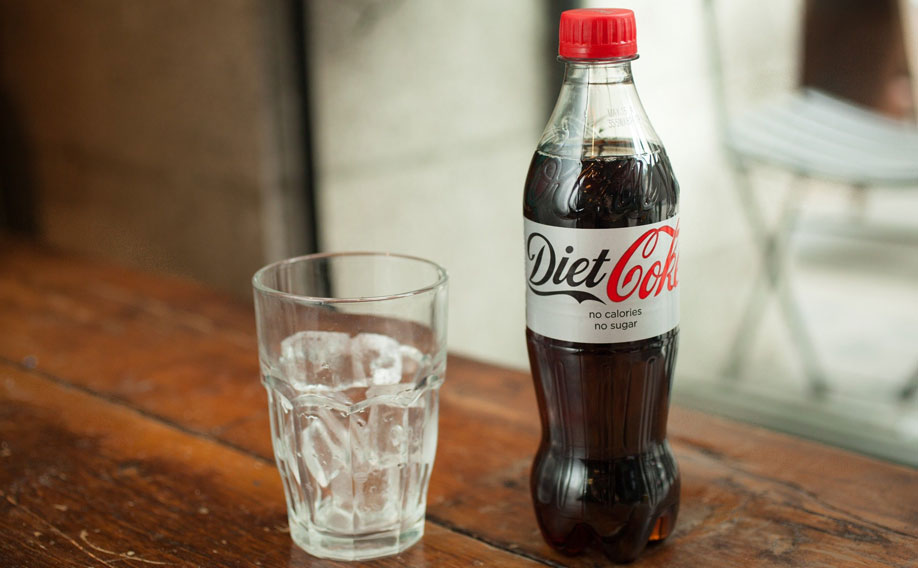



Cluster size: 2
image_path:  ././notebooks/OTF Image Bank/Drinks/hotchocolate.jpg


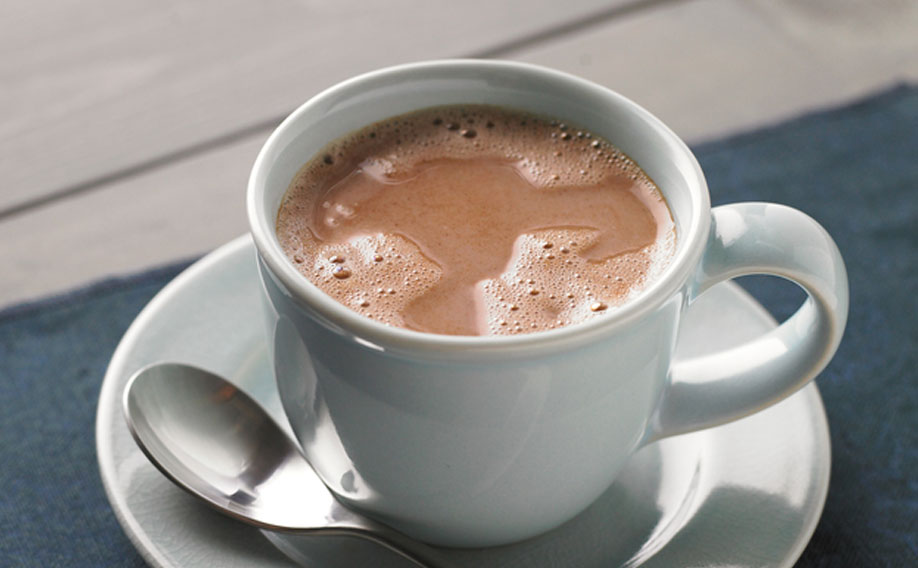

image_path:  ././notebooks/OTF Image Bank/Drinks/choco.jpg


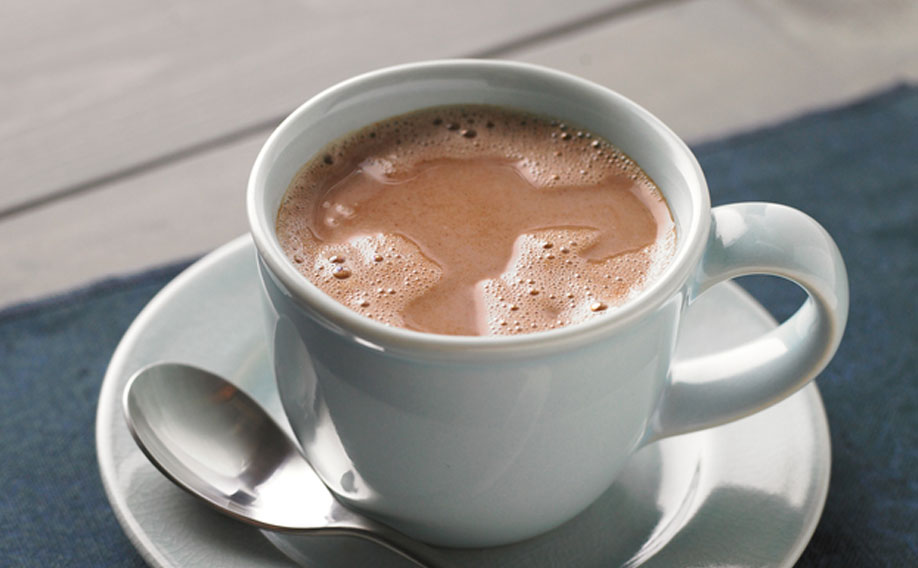



Cluster size: 2
image_path:  ././notebooks/OTF Image Bank/Alcoholic/Dinner Drinks/Dinner-Drinks.jpg


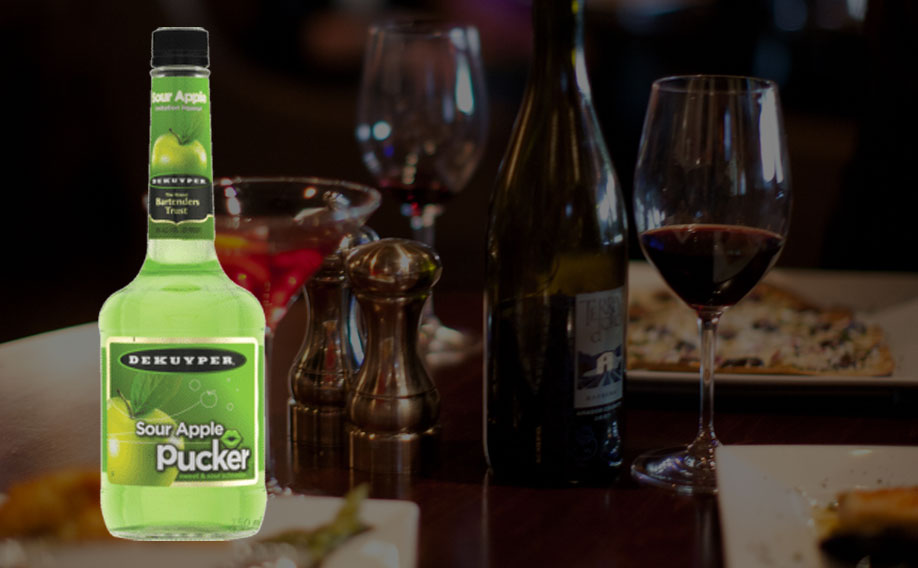

image_path:  ././notebooks/OTF Image Bank/Alcoholic/Dinner Drinks/apple.jpg


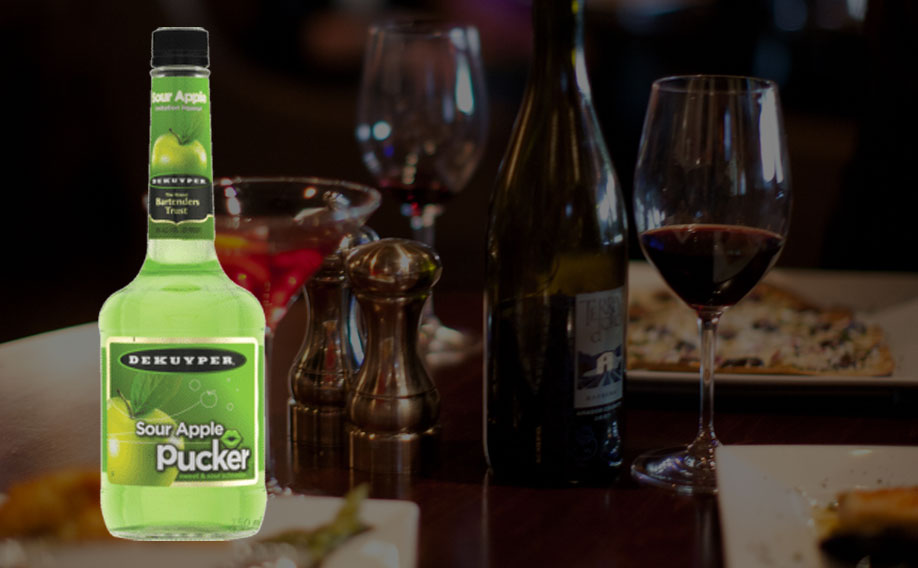



Cluster size: 2
image_path:  ././notebooks/OTF Image Bank/Food/Desserts/3LechesCho.jpg


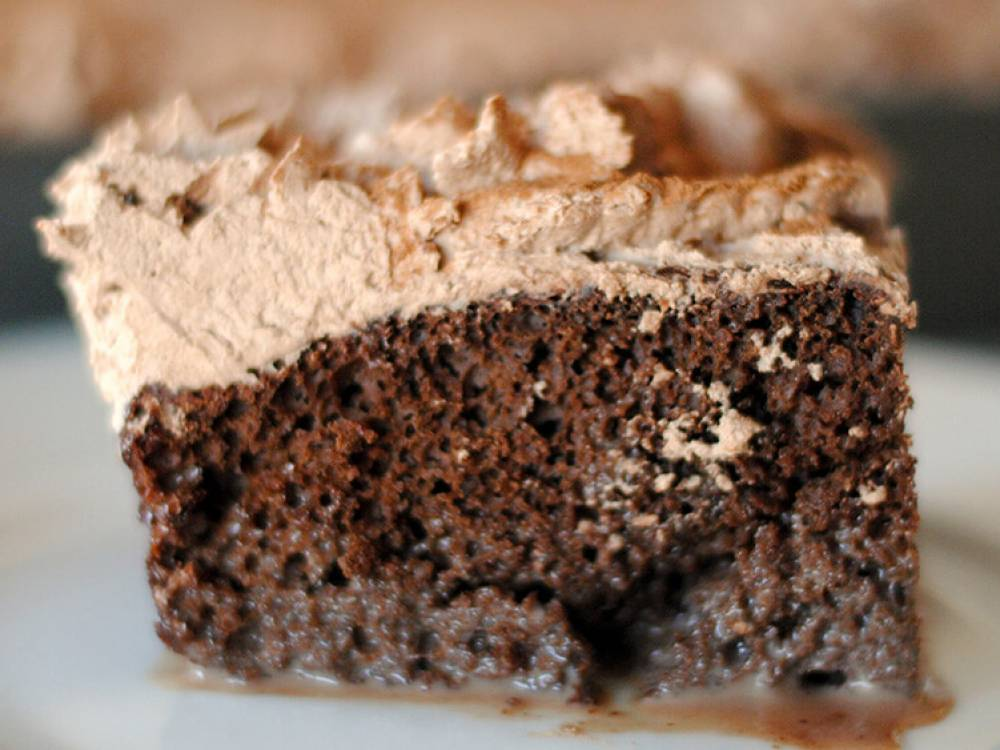

image_path:  ././notebooks/OTF Image Bank/Food/3LechesCho.jpg


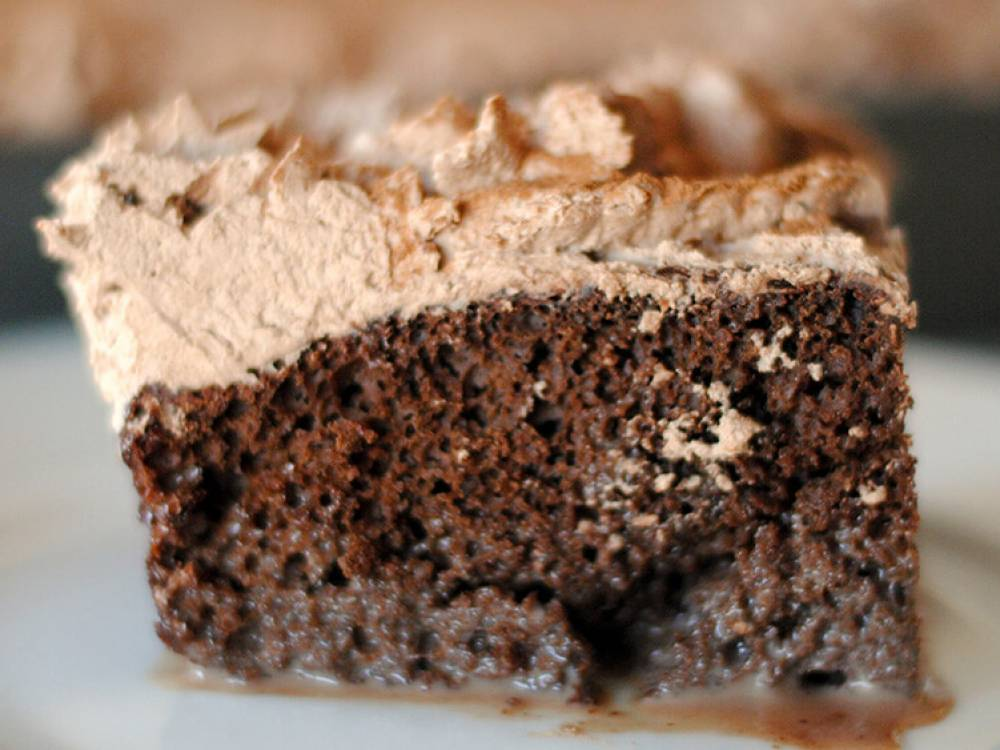



Cluster size: 2
image_path:  ././notebooks/OTF Image Bank/Food/4Lecehes.jpg


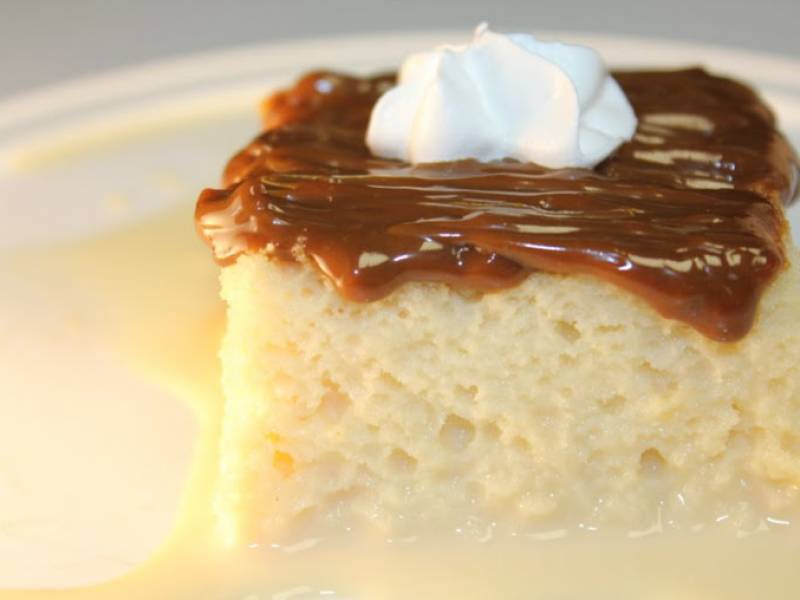

image_path:  ././notebooks/OTF Image Bank/Food/Desserts/4Lecehes.jpg


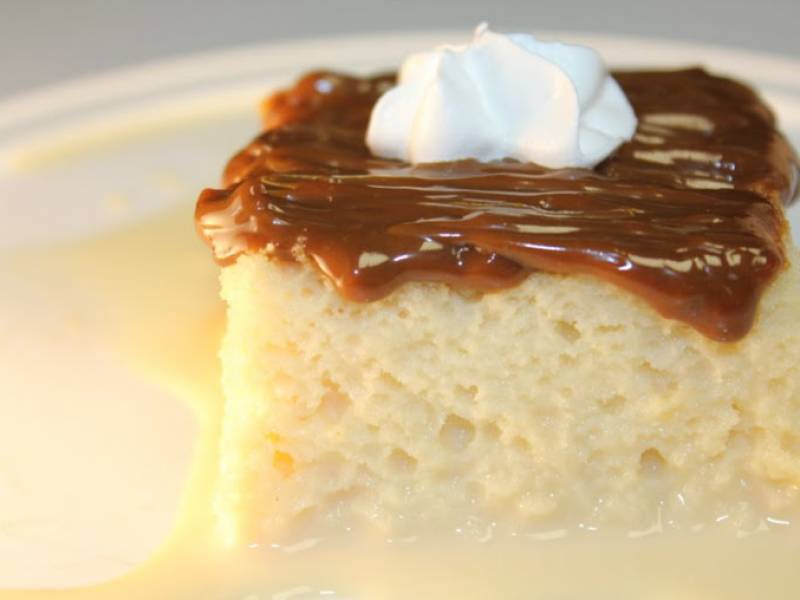



Cluster size: 2
image_path:  ././notebooks/OTF Image Bank/Food/3Leches.jpg


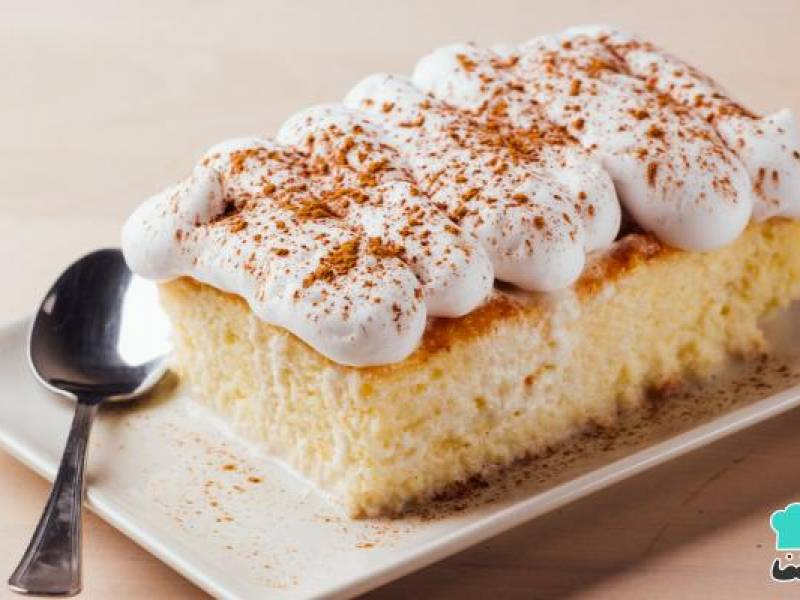

image_path:  ././notebooks/OTF Image Bank/Food/Desserts/3Leches.jpg


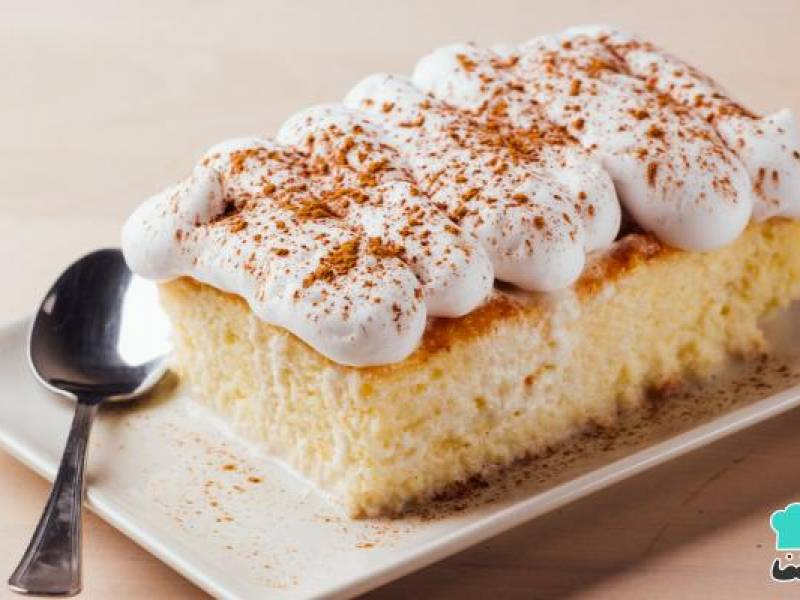



Cluster size: 2
image_path:  ././notebooks/OTF Image Bank/Food/Colombia/tilapia.jpg


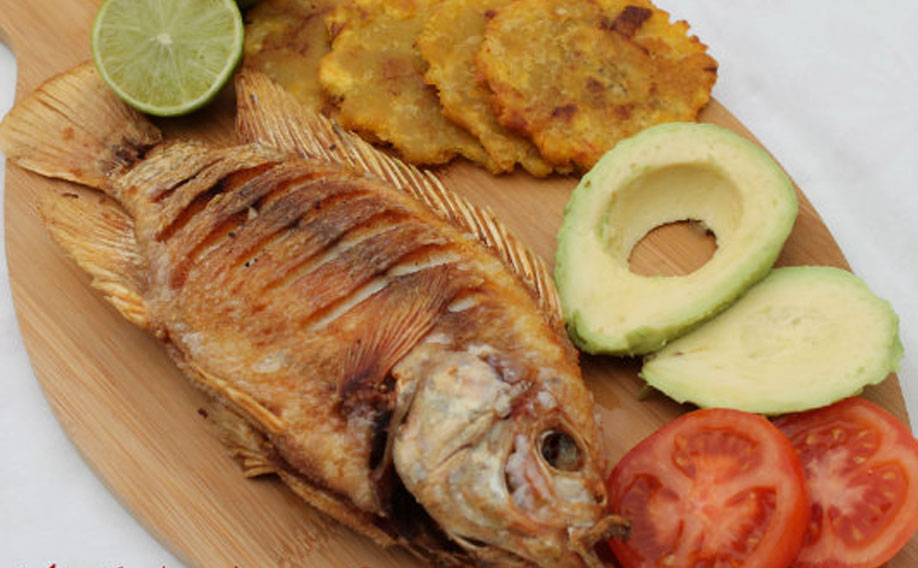

image_path:  ././notebooks/OTF Image Bank/Food/Colombia/Platos2.jpg


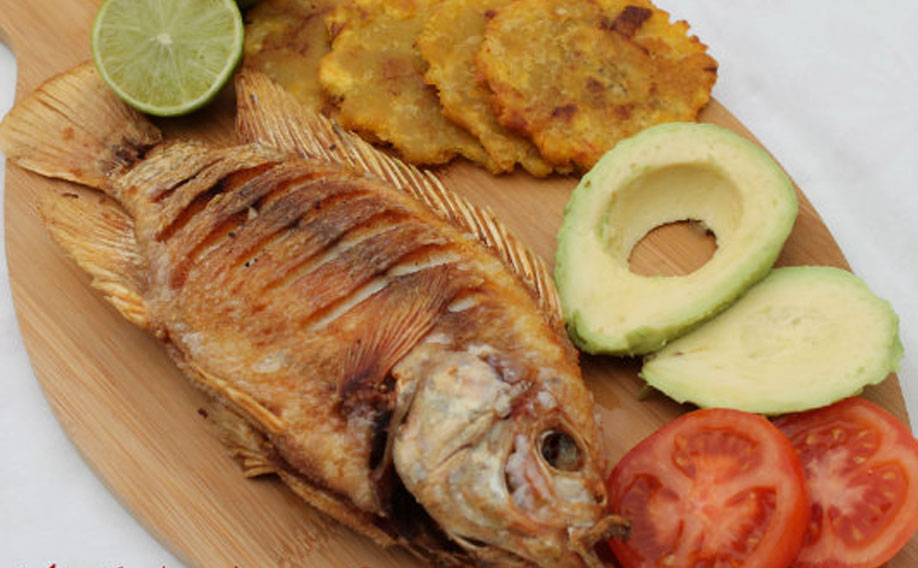



Cluster size: 2
image_path:  ././notebooks/OTF Image Bank/Food/Desserts/4leches.jpg


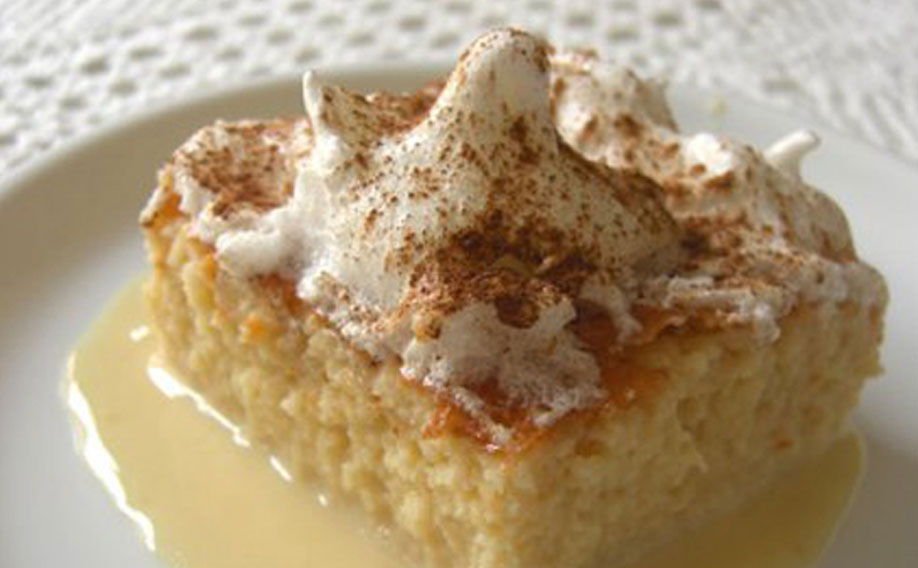

image_path:  ././notebooks/OTF Image Bank/Food/Colombia/4leches.jpg


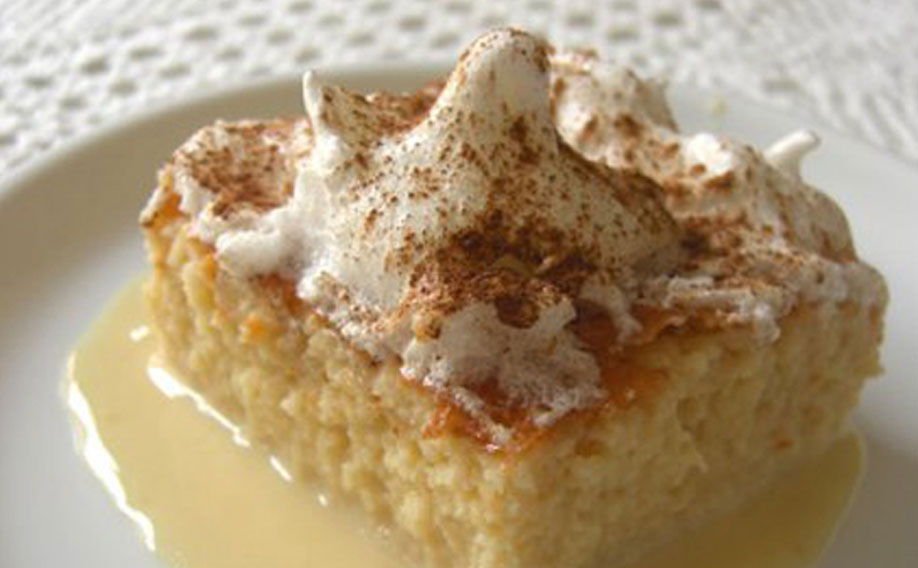

In [11]:
# Now we output the first 10 (largest) clusters

for cluster in clusters[0:10]:
    print("\n\nCluster size:", len(cluster))
    # if len(cluster) == 3:
    #Output 3 images
    for idx in cluster[0:4]:
        image_path = os.path.join('.', img_names[idx])
        print('image_path: ', image_path )
        display(IPImage(image_path, width=300))


In [41]:
os.remove('././notebooks/OTF Image Bank/Alcoholic/Martini/well.jpg')

In [12]:
# delete one of the pairs of images
for cluster in clusters[0:10]:
    print("\n\nCluster size:", len(cluster))
    if len(cluster) == 2:
        # Delete one of the images
        # os.remove(img_names[cluster[0]])
        #Output 3 images
        for idx in cluster[0:4]:
            image_path = os.path.join('.', img_names[idx])
            print('image_path: ', image_path )
            os.remove(image_path)
            break
    print("hey")



Cluster size: 3
hey


Cluster size: 2
image_path:  ././notebooks/OTF Image Bank/Drinks/dietcoke.jpg
hey


Cluster size: 2
image_path:  ././notebooks/OTF Image Bank/Drinks/hotchocolate.jpg
hey


Cluster size: 2
image_path:  ././notebooks/OTF Image Bank/Alcoholic/Dinner Drinks/Dinner-Drinks.jpg
hey


Cluster size: 2
image_path:  ././notebooks/OTF Image Bank/Food/Desserts/3LechesCho.jpg
hey


Cluster size: 2
image_path:  ././notebooks/OTF Image Bank/Food/4Lecehes.jpg
hey


Cluster size: 2
image_path:  ././notebooks/OTF Image Bank/Food/3Leches.jpg
hey


Cluster size: 2
image_path:  ././notebooks/OTF Image Bank/Food/Colombia/tilapia.jpg
hey


Cluster size: 2
image_path:  ././notebooks/OTF Image Bank/Food/Desserts/4leches.jpg
hey


In [ ]:
for cluster in clusters[0:10]:
    if len(cluster) == 2:
        print()

### Find Similar Image

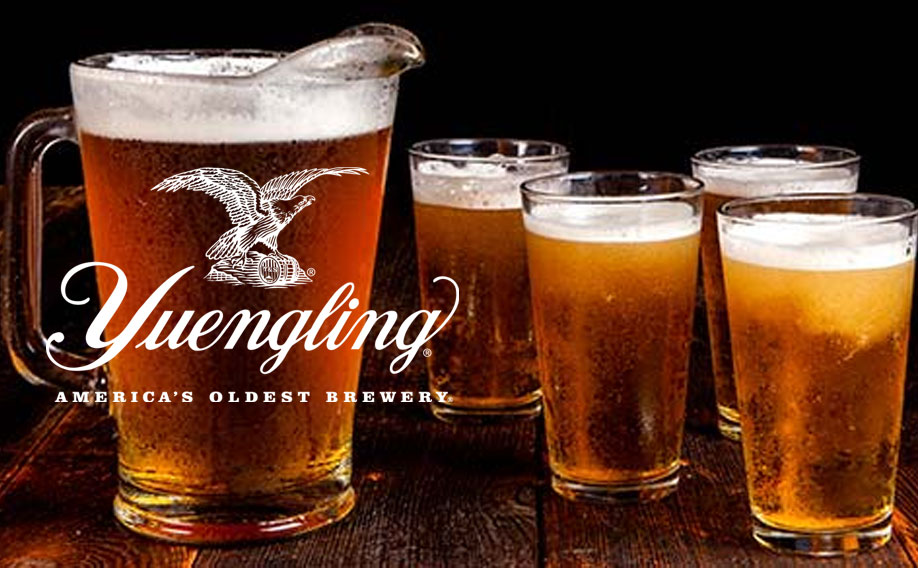

In [14]:
test_image = 'yueng.jpg'

Image.open(test_image)

In [15]:
test_emb = model.encode(Image.open(test_image))

In [16]:
#Compute cosine similarities 
cosine_scores = util.cos_sim(test_emb, img_emb)
print(cosine_scores)

tensor([[0.6976, 0.5466, 0.5994, 0.5083, 0.7069, 0.6269, 0.6454, 0.7175, 0.7032,
         0.6723, 0.6183, 0.6395, 0.6741, 0.5089, 0.5288, 0.6259, 0.6888, 0.6224,
         0.6543, 0.6285, 0.5227, 0.4526, 0.5052, 0.5744, 0.7255, 0.6764, 0.6441,
         0.5451, 0.6661, 0.5322, 0.6919, 0.7894, 0.6339, 0.5503, 0.5563, 0.6748,
         0.5849, 0.6213, 0.4987, 0.6668, 0.5403, 0.5304, 0.6837, 0.6811, 0.5964,
         0.6763, 0.6740, 0.5128, 0.6713, 0.6643, 0.6352, 0.6093, 0.5130, 0.4458,
         0.6419, 0.5977, 0.6197, 0.5371, 0.6139, 0.6069, 0.5509, 0.7024, 0.5677,
         0.4263, 0.5220, 0.6210, 0.5712, 0.5809, 0.8359, 0.6952, 0.6606, 0.5559,
         0.5503, 0.6943, 0.5331, 0.5286, 0.4940, 0.4961, 0.5066, 0.7057, 0.6082,
         0.4971, 0.6614, 0.6971, 0.5376, 0.6787, 0.7362, 0.7105, 0.5390, 0.5513,
         0.5916, 0.6732, 0.6225, 0.6536, 0.4791, 0.6525, 0.7189, 0.4921, 0.5479,
         0.6188, 0.6380, 0.5449, 0.6701, 0.7068, 0.6702, 0.5116, 0.6277, 0.6337,
         0.6471, 0.5131, 0.5

In [19]:
%%time

#Find the pairs with the highest cosine similarity scores
pairs = []
for i in range(len(cosine_scores[0])):
    pairs.append({'index': i, 'score': cosine_scores[0][i]})

CPU times: user 1.36 ms, sys: 2.43 ms, total: 3.8 ms
Wall time: 2.51 ms


In [20]:
len(cosine_scores)

1

In [21]:
pairs = sorted(pairs, key=lambda x: x['score'], reverse=True)

In [22]:
pairs

[{'index': 273, 'score': tensor(1.0000)},
 {'index': 444, 'score': tensor(0.8504)},
 {'index': 68, 'score': tensor(0.8359)},
 {'index': 394, 'score': tensor(0.8324)},
 {'index': 377, 'score': tensor(0.8035)},
 {'index': 248, 'score': tensor(0.7956)},
 {'index': 476, 'score': tensor(0.7955)},
 {'index': 439, 'score': tensor(0.7949)},
 {'index': 382, 'score': tensor(0.7918)},
 {'index': 31, 'score': tensor(0.7894)},
 {'index': 228, 'score': tensor(0.7825)},
 {'index': 352, 'score': tensor(0.7813)},
 {'index': 170, 'score': tensor(0.7770)},
 {'index': 212, 'score': tensor(0.7728)},
 {'index': 194, 'score': tensor(0.7674)},
 {'index': 406, 'score': tensor(0.7649)},
 {'index': 400, 'score': tensor(0.7619)},
 {'index': 196, 'score': tensor(0.7583)},
 {'index': 418, 'score': tensor(0.7570)},
 {'index': 300, 'score': tensor(0.7512)},
 {'index': 470, 'score': tensor(0.7503)},
 {'index': 200, 'score': tensor(0.7492)},
 {'index': 461, 'score': tensor(0.7479)},
 {'index': 375, 'score': tensor(0.74

273


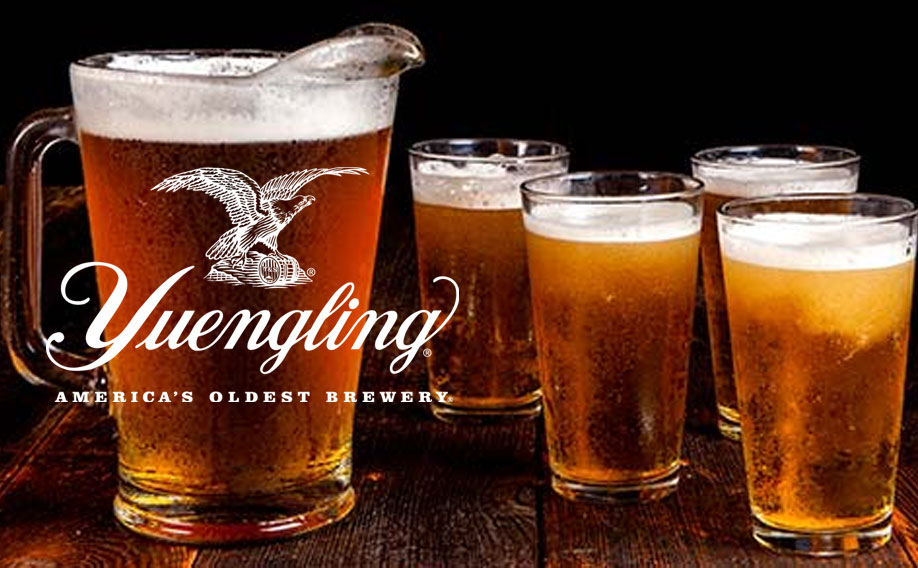

444


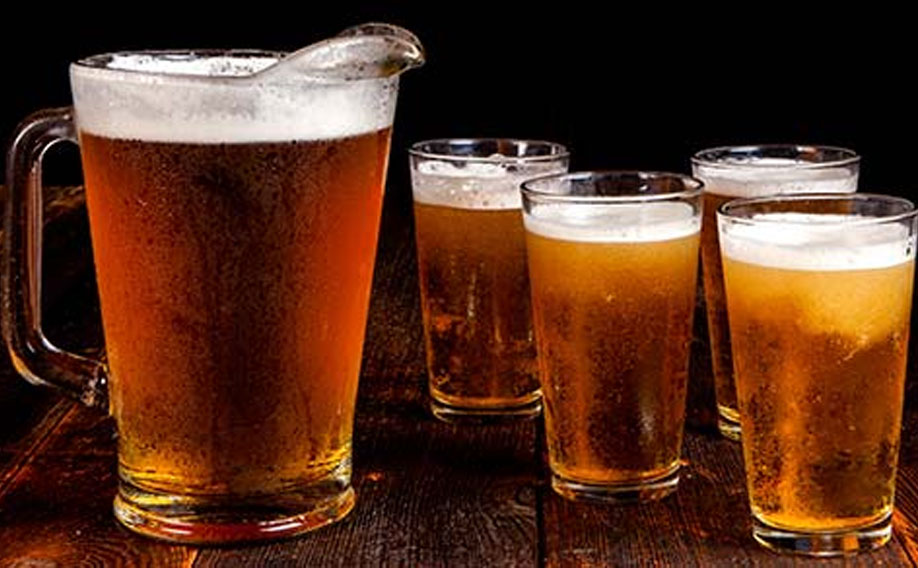

68


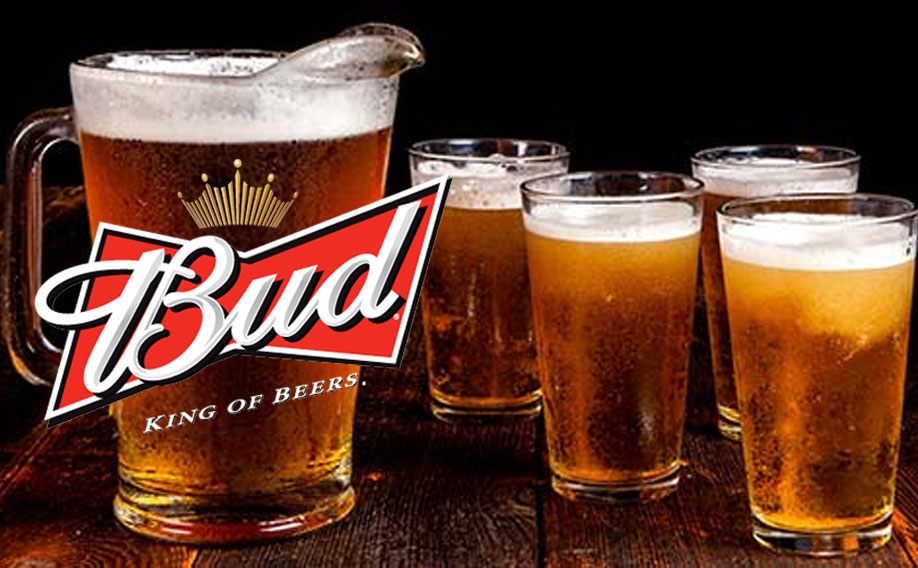

394


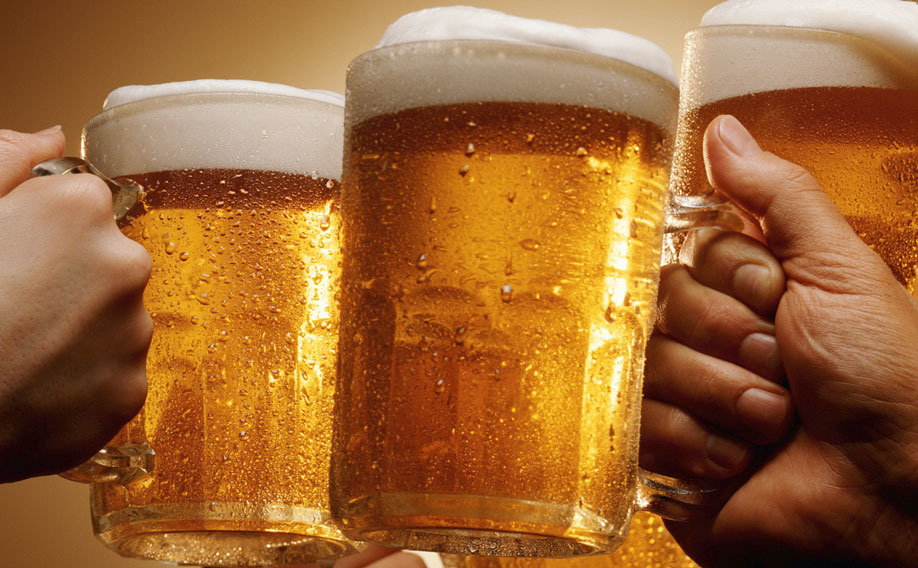

377


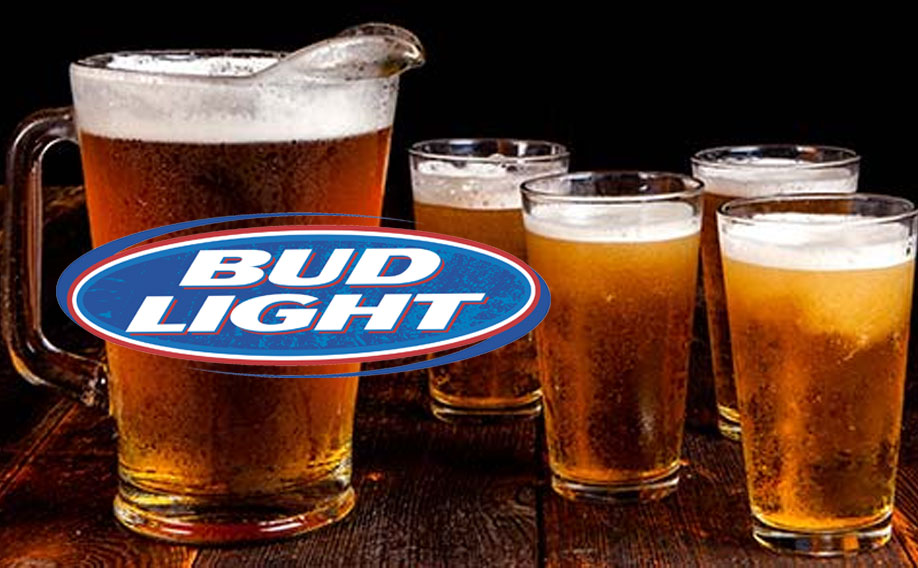

248


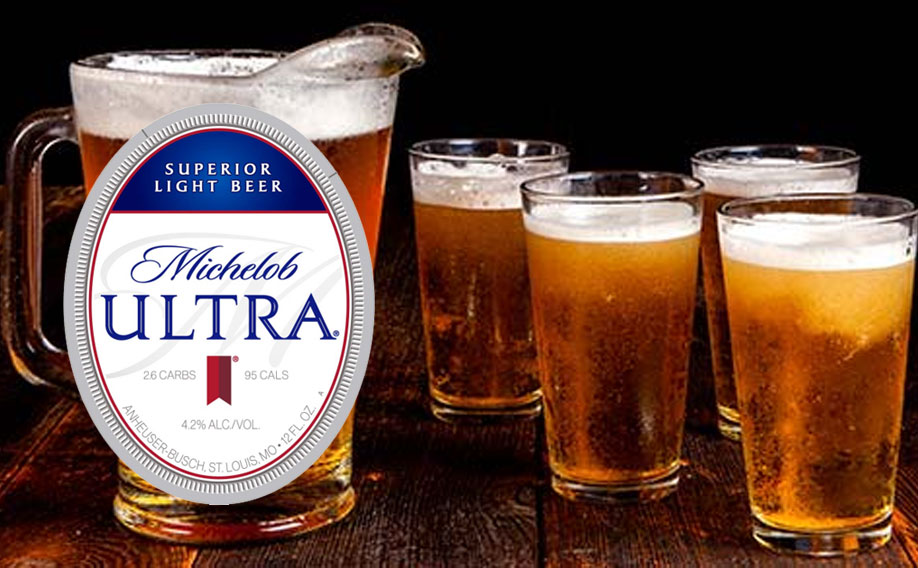

476


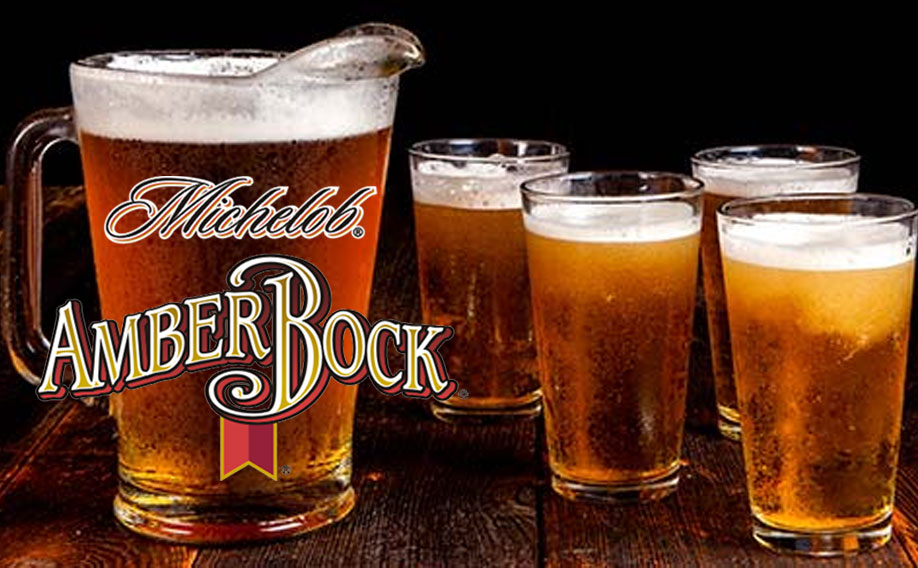

439


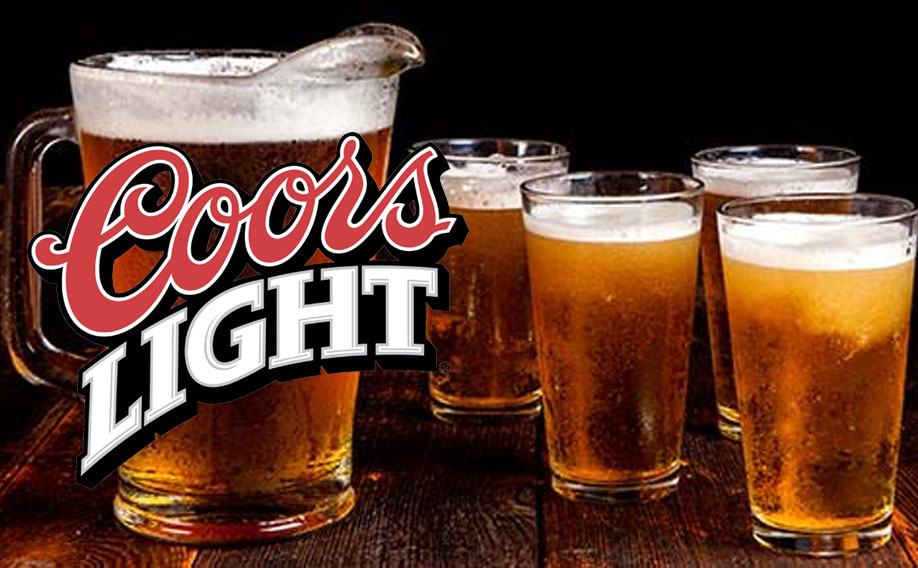

382


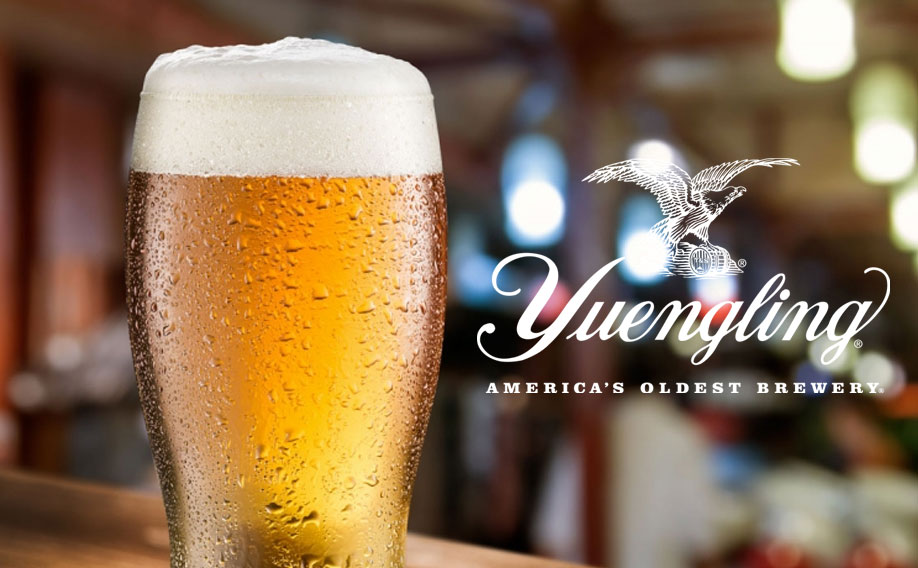

31


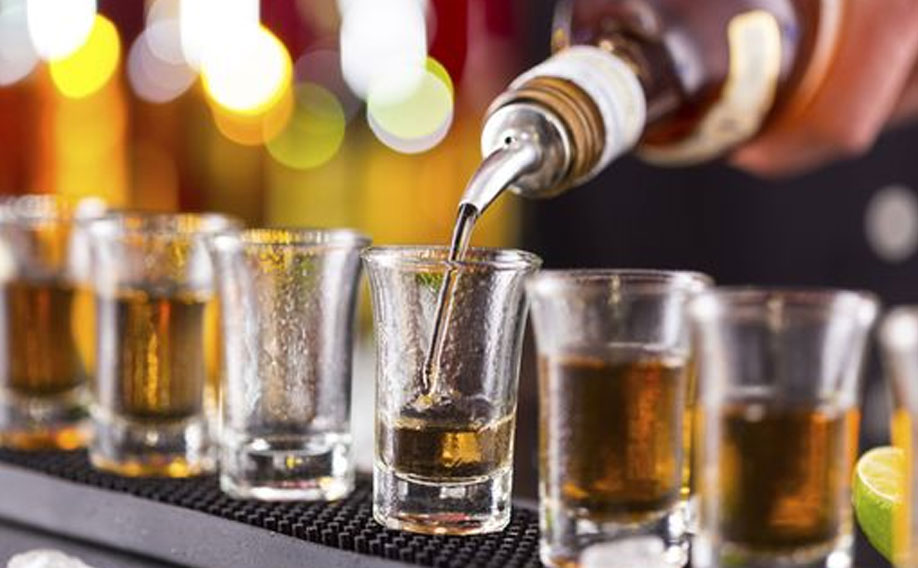

CPU times: user 22.1 ms, sys: 11.4 ms, total: 33.5 ms
Wall time: 56.1 ms


In [24]:
%%time

for pair in pairs[0:10]:
    i = pair['index']
    #print("{} \t\t {} \t\t Score: {:.4f}".format(sentences[i], sentences[j], pair['score']))
    print(i)
    display(IPImage(os.path.join('.', img_names[i]), width=200))
